In [5]:
import numpy as np
from numpy import savetxt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation

In [2]:
class Randomizer:
    
    def __init__(self, seed):
        self.seed = seed
        
    def rnd(self):
        '''
        Generates a single pseudo-random number between 0 and 1.
        '''
        m = 2**31 - 1
        a = 630360016
        temp = self.seed * a
        self.seed = temp % m
        return self.seed / m
    
    def rndv(self, n):
        '''
        Generates a vector of n pseudo-random numbers between 0 and 1.
        '''
        if n > 0:
            m = 2**31 - 1
            a = 630360016
            rvec = np.empty(n, dtype = float)
            temp = self.seed * a
            rvec[0] = temp % m
            for i in range(1, n):
                temp = rvec[i-1] * a
                rvec[i] = temp % m
            self.seed = rvec[-1]
            rvec /= m
            return rvec
        else:
            return None
    
    def nrnd(self):
        '''
        Generates a single standard normal random number (mean 0, variance 1).
        '''
        accum = 0
        N = 14
        for i in range(N):
            accum += self.rnd()
        return accum - N/2
    
    def nrndv(self, n):
        '''
        Generates a vector of n standard normal random numbers.
        '''
        accum = np.zeros(n)
        N = 12
        for i in range(N):
            accum += self.rndv(n)
        return (2*accum - N)*((3/N)**(0.5))

In [20]:
def getRN(p, p_all):
    '''
    Calculate normilized vectors between one point and all the others
    '''
    n, dims = p_all.shape
    temp = np.repeat(p, n, axis=0).reshape((dims,n)).transpose()
    dists = np.apply_along_axis(np.linalg.norm,1,temp-p_all)
    norm = np.repeat(dists, dims, axis=0).reshape((n, dims))
    temp = (temp - p_all)/norm
    return temp

def getEDists(p, p_all):
    '''
    Calculate Euclidean distance between one point and all the others
    '''
    n, dims = p_all.shape
    temp = np.repeat(p, n, axis=0).reshape((dims,n)).transpose()
    dists = np.apply_along_axis(np.linalg.norm,1,temp-p_all)
    return dists

def LJP(d, sig, e):
    '''
    Lennard-Johns Force 
    '''
    di = 1/d
    di6 = di**6
    s6 = sig**6
    F = 24*e*s6*di*di6*(2*s6*di6-1)
    return F

def getA(p, sig, e):
    '''
    Calculate acceleration
    '''
    n = p.shape[0]
    a = np.array([np.sum(np.repeat(LJP(getEDists(p[i], np.delete(p, i, 0)), sig, e), dims, axis=0).reshape((n-1, dims)) * 
                getRN(p[i], np.delete(p, i, 0)), axis = 0) for i in range(len(p))])
    return a

def visualize(p, w):
    '''
    Plot our molecules in 2D plane
    '''
    plt.figure(dpi = 300, figsize = (3, 2))
    colors = cm.rainbow(np.linspace(0, 1, N))
    plt.scatter(p[:,0], p[:,1], w*scale, colors, edgecolors = "black")
    plt.grid("on")
    plt.rc('axes', axisbelow=True)
    plt.xlim([0, L])
    plt.ylim([0, L])
    plt.show()


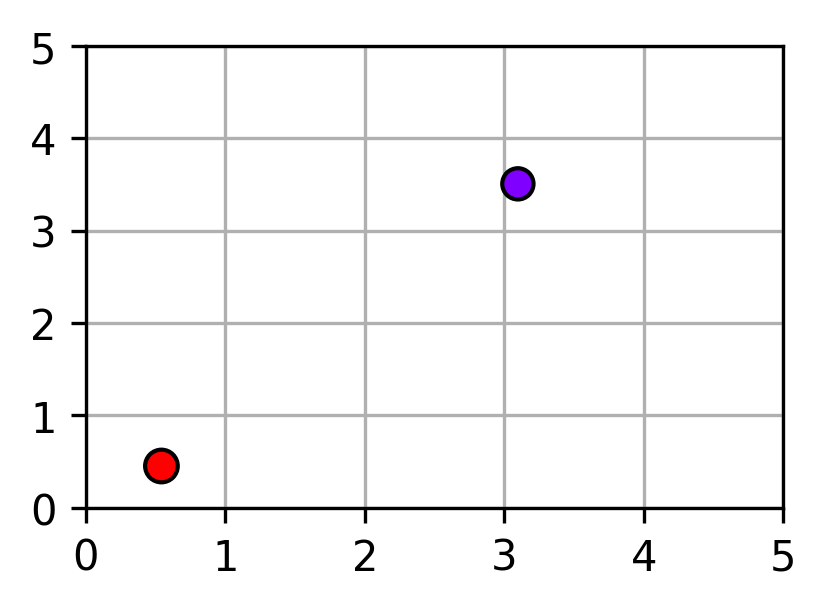

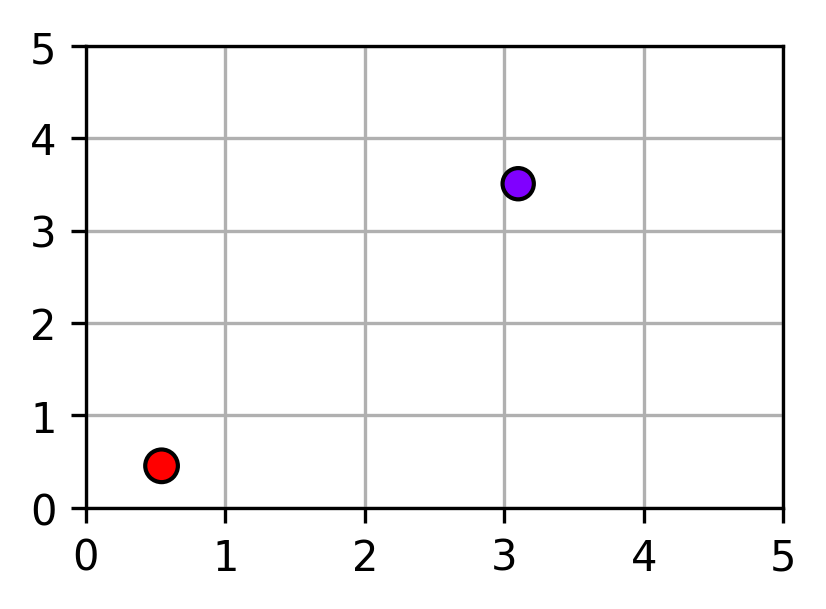

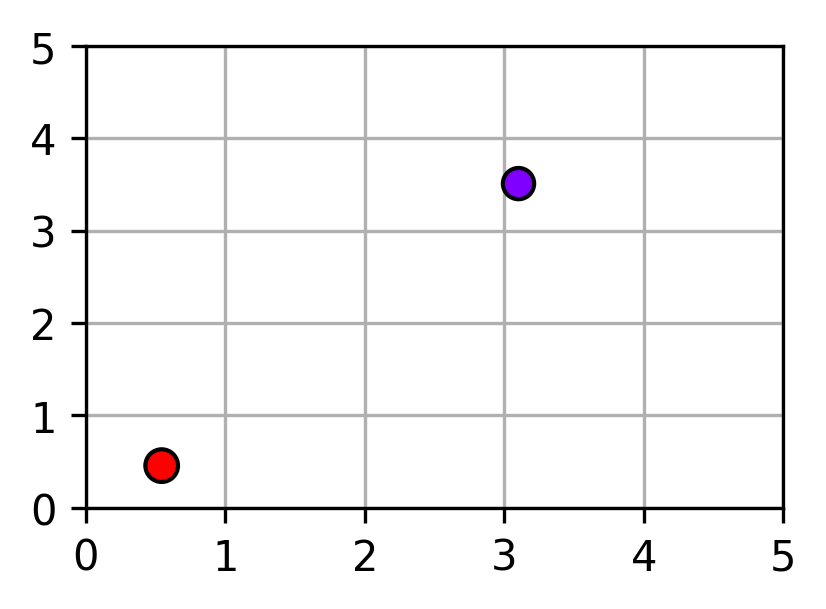

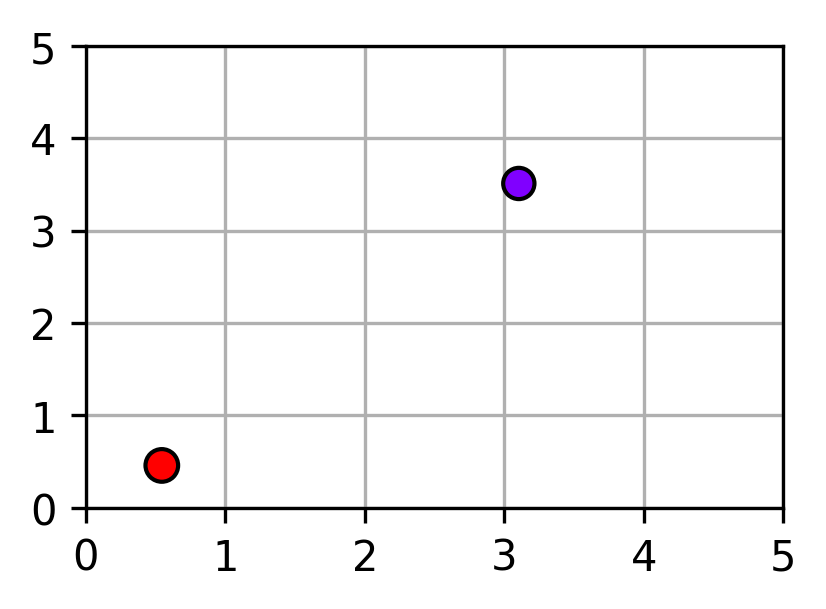

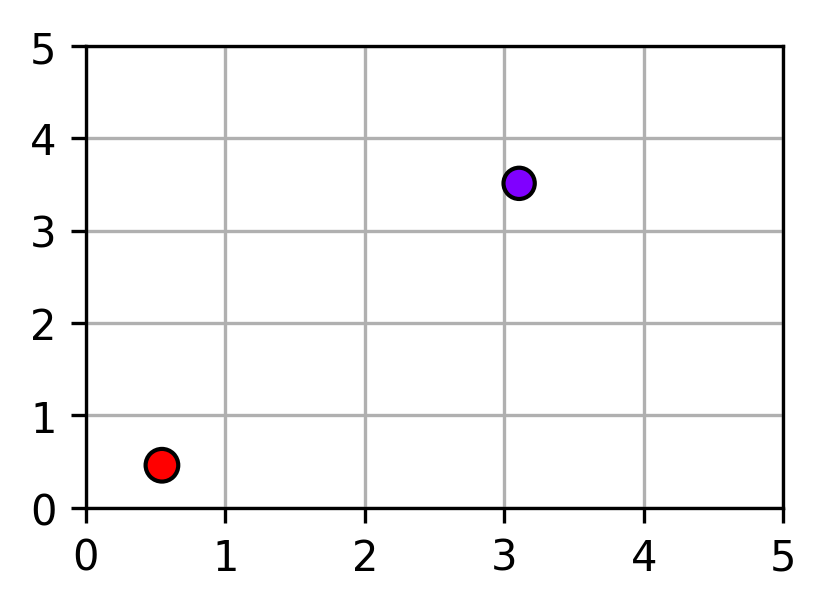

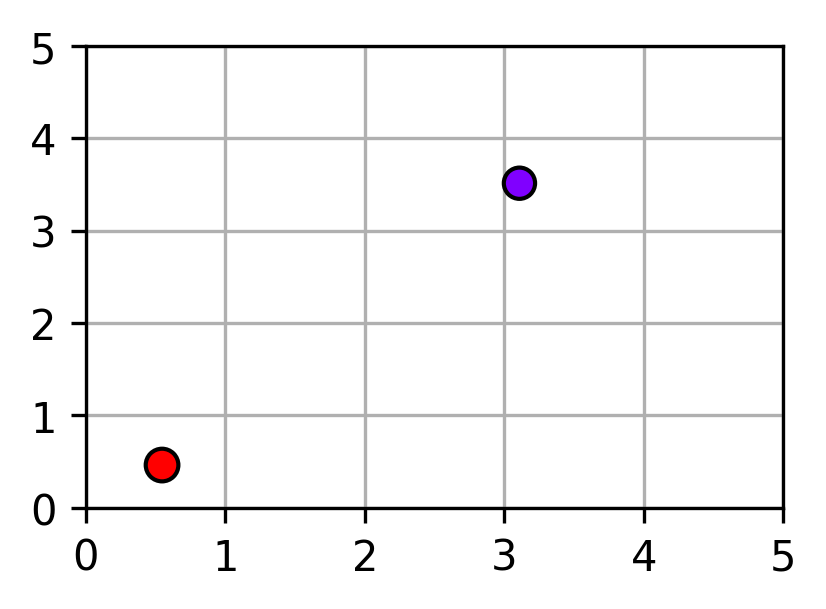

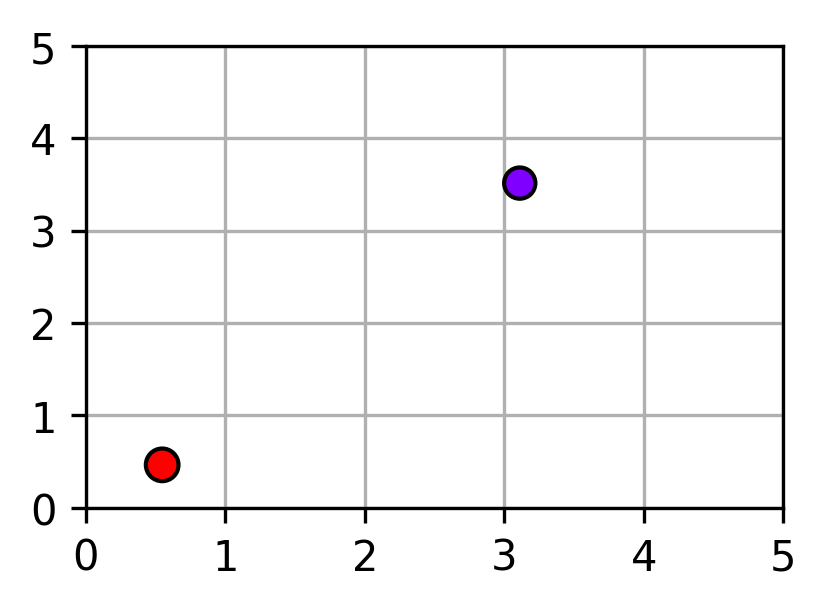

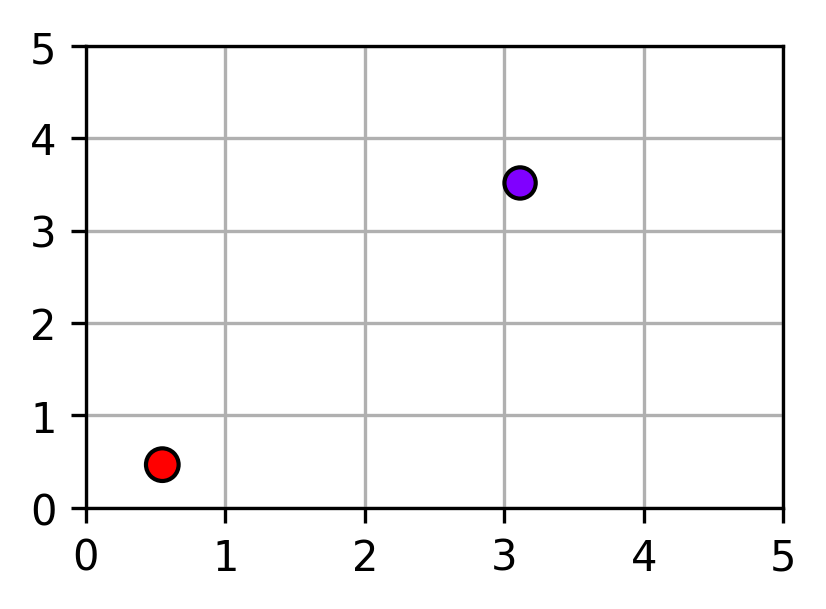

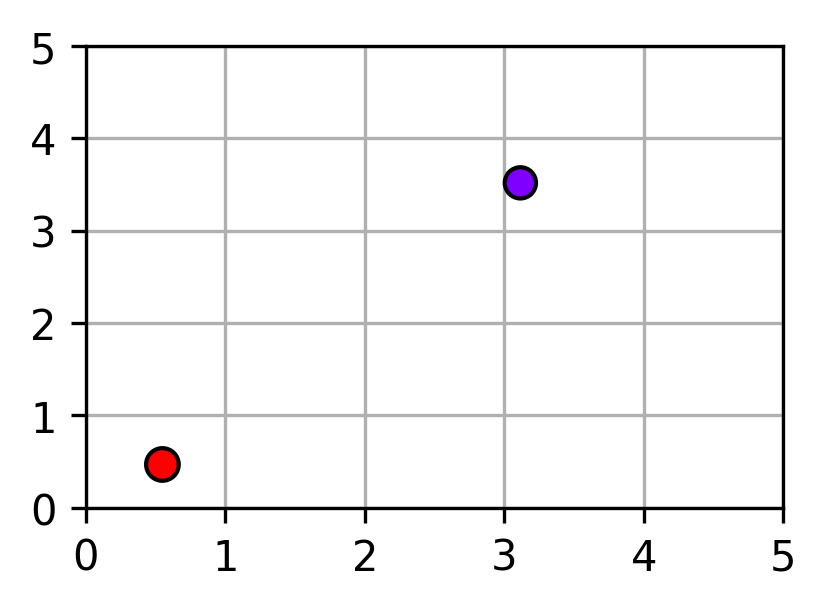

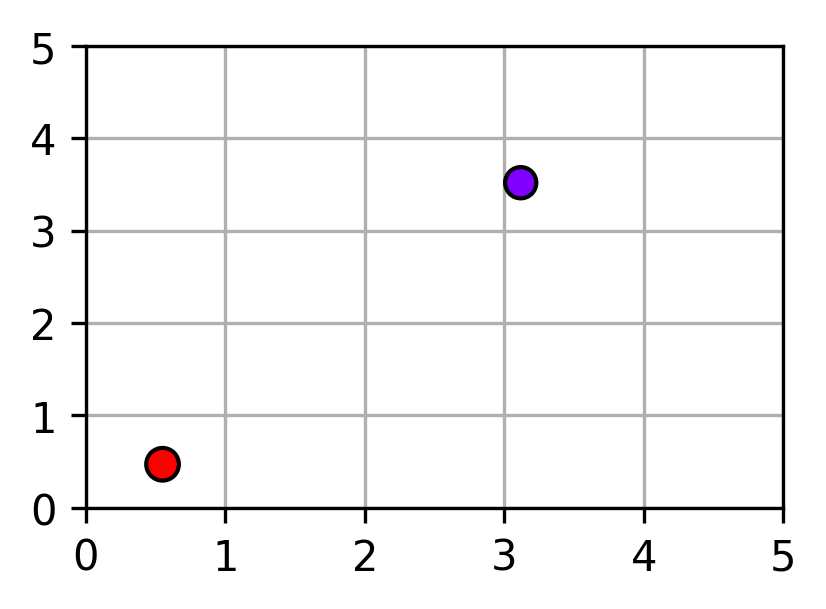

In [31]:
# Randomization params
seed = 40
RNG = Randomizer(seed)

# Accuracy params
eps = 10^-6
dt = 0.005

# System params
L = 5    # Size of the box
T = 0.05  # End-time of simulation
N = 2   # Amount of particles
dims = 2 # Number of dimensions (coordinates)

# LJP params
sig = 1
e = 2

# Plot params
scale = 42

# Particle params ->

# Weight
wmean = 1
wvar = 0.33
w = (wvar * RNG.nrndv(N) + wmean) # Normal distribution
w[w <= 0] = eps # With cutted down negative values
wd = np.repeat(w, dims, axis=0).reshape((N,dims))  # Создаёт массив весов для каждой координаты частиц.

# Coordinates vector (Rows - points, Columns - coordinates)
p = np.array([RNG.rndv(dims)*L for i in range(N)]) # Инициализирует начальные координаты частиц в случайных положениях внутри пространства.
#print(p)

# Starting speed
v_max = 0.5
v = np.array([RNG.rndv(dims)*v_max for i in range(N)]) # Инициализирует начальные скорости частиц в случайных направлениях.

# Acceleration
a = getA(p, sig, e) / wd # Вычисляет начальное ускорение частиц на основе их начальных координат и весов.
a_old = 0 # Хранит предыдущее ускорение для использования в методе Верле (для расчёта следующего ускорения).
#print(a)

with open("data.txt", "a") as f:
    f.truncate(0)
    f.write("Initial coordinates \n")
    savetxt(f, p, delimiter=',')

for i in range(int(T/dt)):
    
    # Comment if no visualization needed
    # clear_output(wait = True)
    visualize(p, w)
    
    dp = v * dt + a_old * dt * dt # Вычисляет изменение координат частиц за один шаг времени.
    outs = np.maximum((p+dp) > L, (p+dp) < 0) # Определяет частицы, которые выходят за границы пространства.
    v[outs] = - v[outs] # Меняет направление скорости частиц, которые вышли за границы.
    dp[outs] = - dp[outs] # Отбрасывает часть изменения координат, которая вывела бы частицу за границу.
    p = p + dp # Обновляет координаты частиц.
    a_old = a # Сохраняет текущее ускорение для следующего шага.
    a = getA(p, sig, e) / wd # Вычисляет новое ускорение на основе новых координат.
    v = v + (a + a_old) / 2 * dt # Обновляет скорость частиц с использованием метода Верле.
    with open("data.txt", "a") as f:
        f.write(f"Iteration {i+1} out of {int(T/dt)} \n")
        savetxt(f, p, delimiter=',')
    #time.sleep(0.1)
    #print(p)
    
    '''
    '''